In [1]:
import cv2
import numpy as np

# Simply adding bracketed exposures

In [3]:
img_paths = [
    'data/st_louis/st_louis_0.03.jpg',
    'data/st_louis/st_louis_0.25.jpg',
    'data/st_louis/st_louis_2.5s.jpg',
    'data/st_louis/st_louis_15s.jpg',
]

imgs = [
    cv2.imread(img_path)[..., ::-1]
    for img_path in img_paths
]

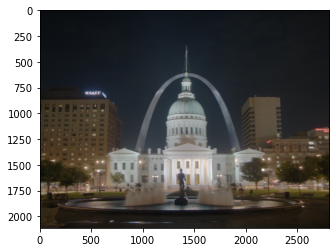

In [13]:
import matplotlib.pyplot as plt

merged_img = np.stack(imgs).mean(axis=0).astype(np.uint8)

plt.imshow(merged_img)

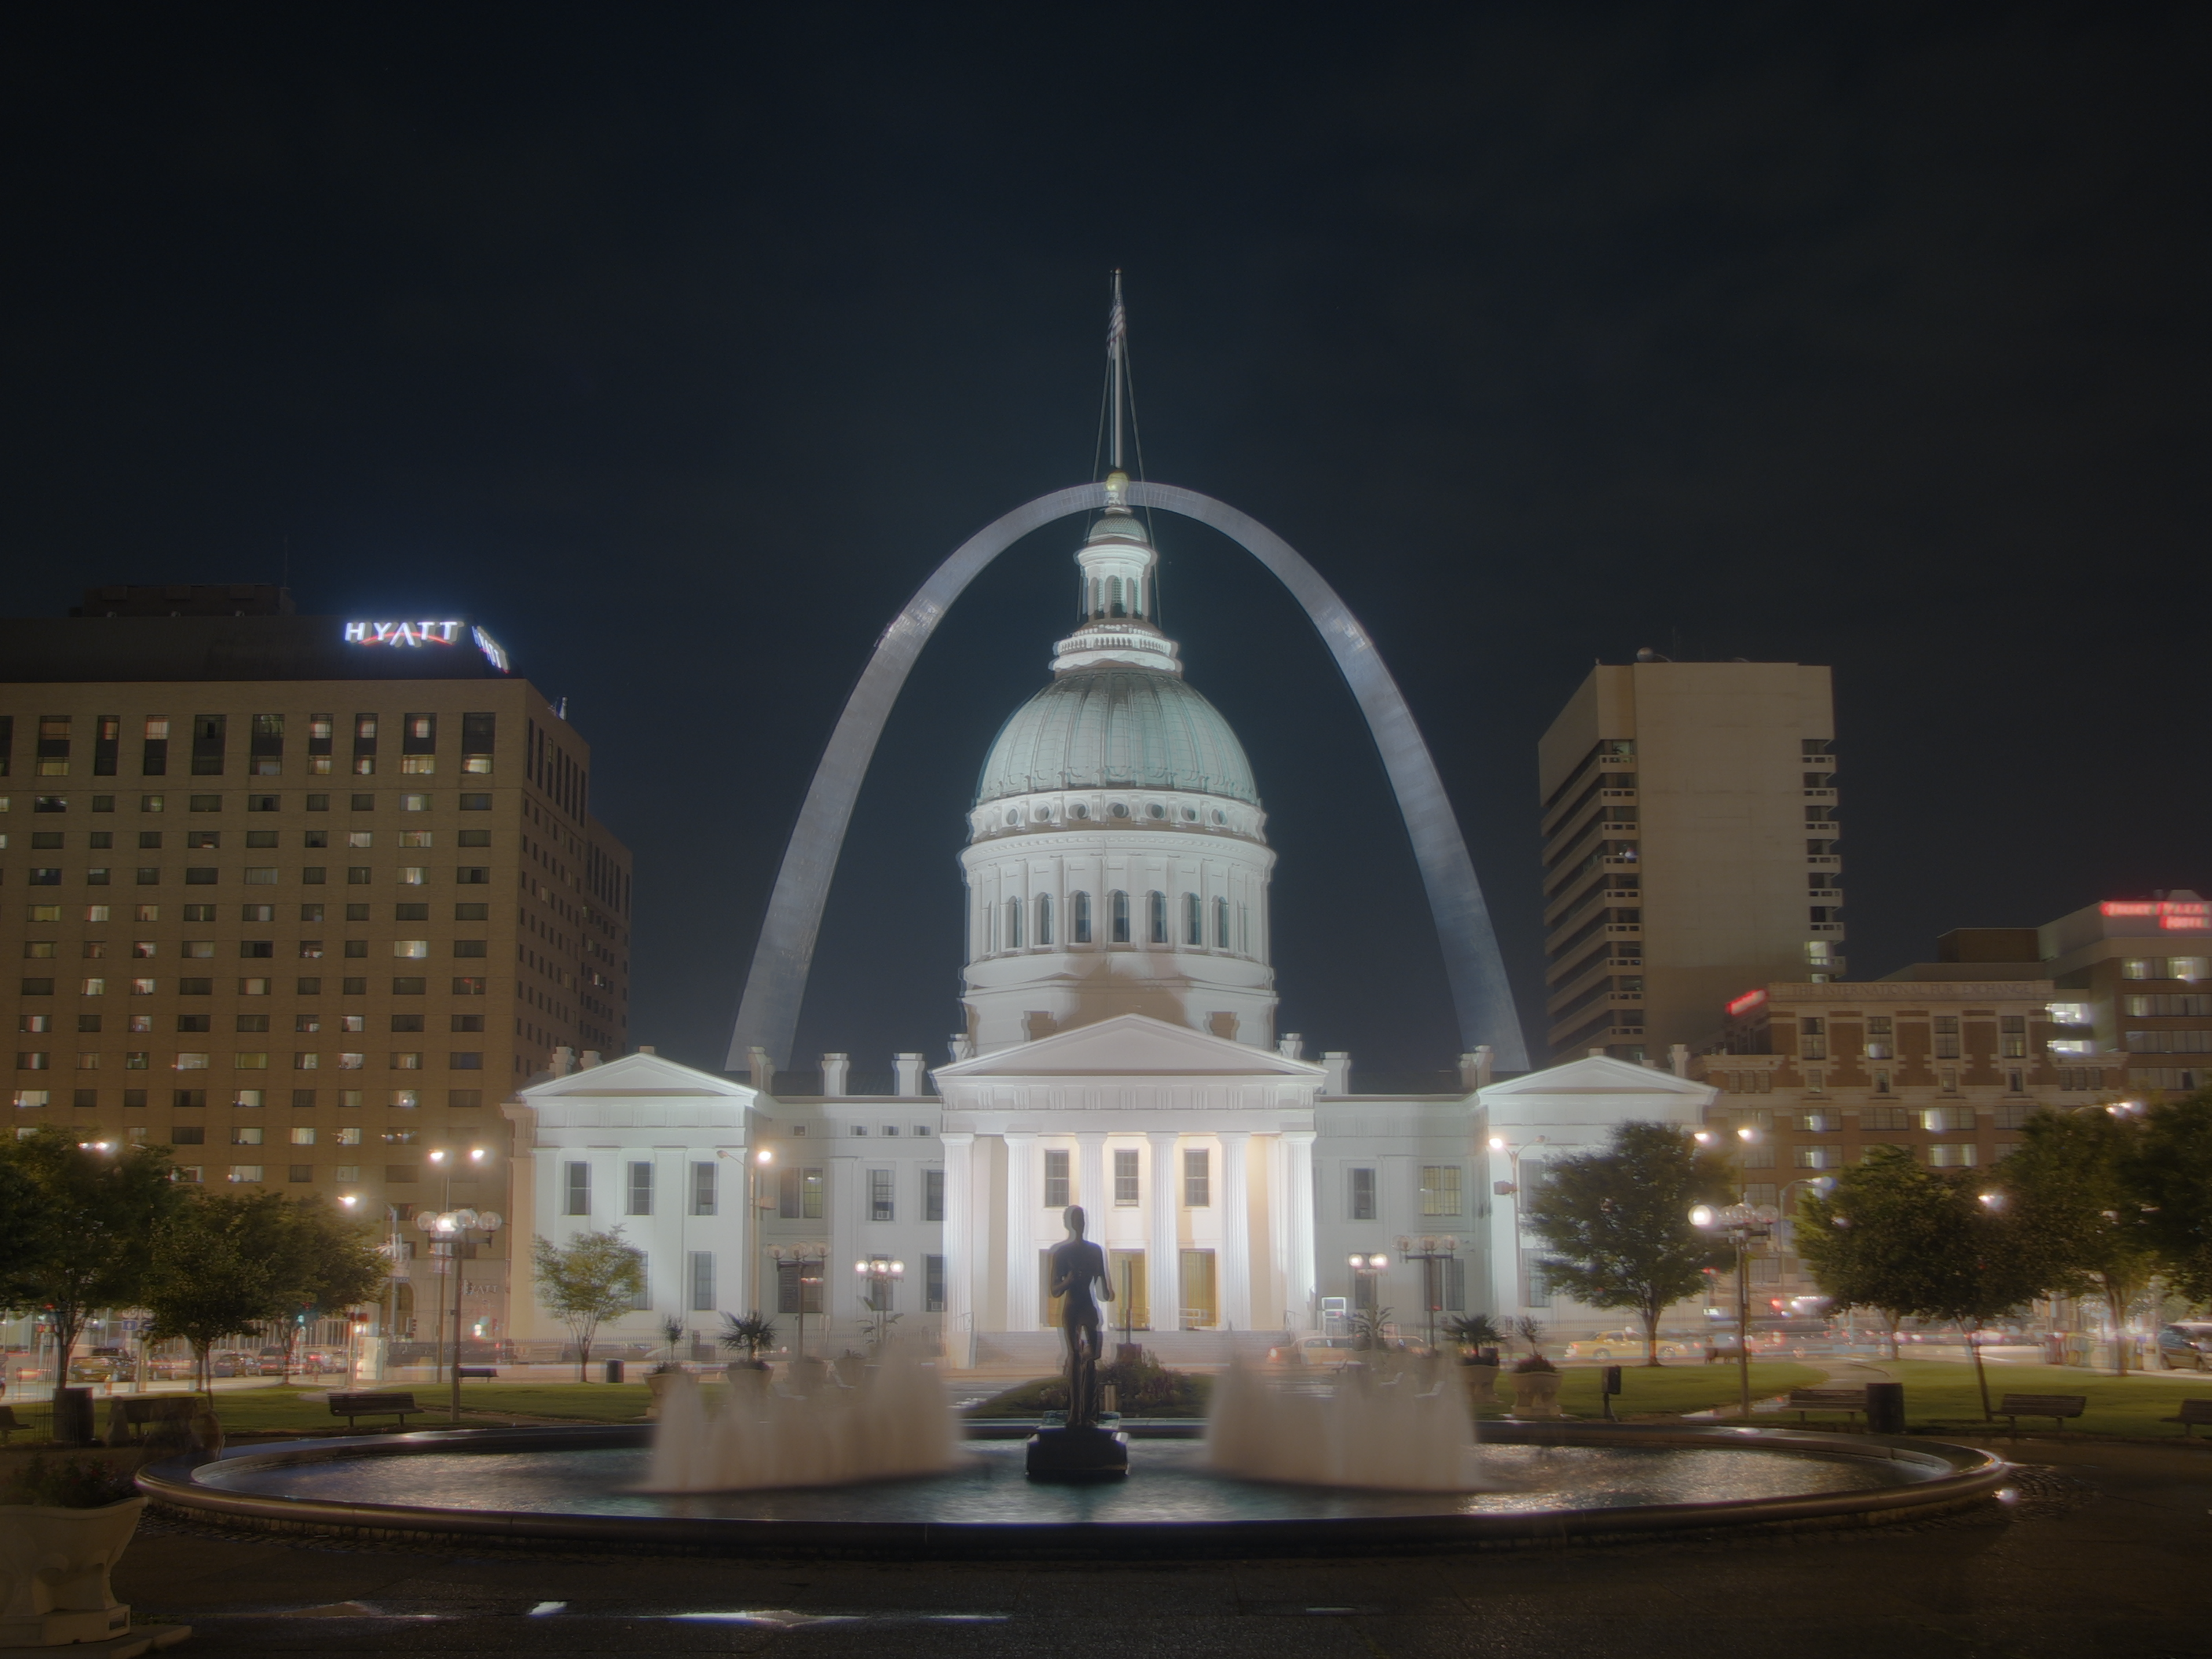

In [14]:
from PIL import Image

Image.fromarray(merged_img)

# Calculate radiometric response function

In [2]:
import pandas as pd

df = pd.read_csv('data/taipei/image_list.csv')
imgs = np.stack(df['Filename'].apply(lambda img: cv2.imread(f'data/taipei/{img}')))
exposure_times = df['exposure'].values

In [3]:
def hdr_debvec(imgs, exposure_times, n_sample_per_dim=20):
    height, width = imgs.shape[1:3]
    width_step = width // n_sample_per_dim
    height_step = height // n_sample_per_dim

    mask = np.zeros((height, width), dtype=np.bool8)
    mask[::height_step, ::width_step] = True

    gs = []
    for channel in range(imgs.shape[-1]):
        Z = imgs[..., mask, channel]

        B = [math.log(e, 2) for e in exposure_times]
        l = 50  # determines the amount of smoothness
        w = [z if z <= 0.5*255 else 255-z for z in range(256)]

        g, _ = response_curve_solver(Z, B, l, w)
        gs.append(g)
    
    return np.hstack(gs)

In [4]:
def response_curve_solver(Z, B, l, w):
    n = 256
    A = np.zeros(shape=(np.size(Z, 0)*np.size(Z, 1)+n+1, n+np.size(Z, 1)), dtype=np.float32)
    b = np.zeros(shape=(np.size(A, 0), 1), dtype=np.float32)

    # Include the data−fitting equations
    k = 0
    for i in range(np.size(Z, 1)):
        for j in range(np.size(Z, 0)):
            z = int(Z[j][i])
            wij = w[z]
            A[k][z] = wij
            A[k][n+i] = -wij
            b[k] = wij*B[j]
            k += 1
    
    # Fix the curve by setting its middle value to 0
    A[k][128] = 1
    k += 1

    # Include the smoothness equations
    for i in range(n-1):
        A[k][i]   =    l*w[i+1]
        A[k][i+1] = -2*l*w[i+1]
        A[k][i+2] =    l*w[i+1]
        k += 1

    # Solve the system using SVD
    x = np.linalg.lstsq(A, b, rcond=-1)[0]
    g = x[:256]
    lE = x[256:]

    return g, lE

In [5]:
response_curve = hdr_debvec(imgs, exposure_times)

# Estimate radiance map

In [6]:
def construct_radiance_map(imgs, response_curve, exposure_times):
    Z = imgs.flatten().reshape(len(imgs), -1, 3)

    resp = np.stack([response_curve[Z[..., i], i]
                     for i in range(Z.shape[-1])], axis=-1)
    ln_t = np.log2(exposure_times)[..., None, None]
    w = np.array([z if z <= 0.5*255 else 255 - z
                  for z in range(256)])
    w_z = w[Z]
    acc_e = np.sum(w_z * (resp - ln_t), 0)
    acc_w = np.sum(w_z, 0)
    acc_w[acc_w <= 0] = 1

    return acc_e/acc_w

In [7]:
def construct_hdr(imgs, response_curve, exposure_times):
    E = construct_radiance_map(imgs, response_curve, exposure_times)
    return np.reshape(np.exp(E), imgs.shape[1:])

In [8]:
hdr = construct_hdr(imgs, response_curve, exposure_times)

In [9]:
hdr.shape

(510, 768, 3)

# Tone map

In [10]:
tonemap = cv2.createTonemapDrago(5)
ldr = tonemap.process(hdr) * 255

error: OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/photo/src/tonemap.cpp:69: error: (-215:Assertion failed) _src.dims() == 2 && _src.type() == CV_32FC3 in function 'process'
